This function takes historic use data, weather data, and the cluster codebook and creates a regression model per cluster.  Then, it predicts use based on weather inputs. To actually forecast, provide anticipated weather for the number of days/hours into the future to forecast.

# Forecasting #

In [1]:
# imports
import pandas as pd
import numpy as np
import time
from timeit import default_timer as timer

In [2]:
# define data location
# location = '/Users/mithras/Documents/_SCHOOL/_Drexel/BUSN 710 - Capstone/Data/Forecasting Project/'
location = '/Users/loki/Documents/_SCHOOL/_Drexel/BUSN 710 - Capstone/Data/Forecasting Project/'

In [38]:
# load data
granularity = "daily"
start = timer()

if granularity == "daily":
    readdata = pd.read_pickle(location+'fcast_daily.pkl.zip') # 2 years of data
    weather = pd.read_pickle(location+'daily_weather.pkl.zip')
    weather = weather[['Dt','LowDB1','LowDB1delta']]
#     codebook = pd.read_pickle(location+'codebook.pkl.zip') # original clusters
    codebook = pd.read_pickle(location+'final_codebook_combined_v2.pkl.zip') # group1 and 2 clusters on dmeterno
elif granularity == "hourly":
    readdata = pd.read_pickle(location+'fcast_hourly.pkl.zip') # 2 years of data
    weather = pd.read_pickle(location+'hourly_weather.pkl.zip')
    weather = weather[['Dt','Temp1','Temp5delta']]
#     codebook = pd.read_pickle(location+'codebook.pkl.zip') # original clusters
    codebook = pd.read_pickle(location+'final_codebook_combined_v2.pkl.zip')  # group1 and 2 clusters on dmeterno
else:
    print("Granularity not in ('daily','hourly')")
    
end = timer()
print((end - start)/60) # Time in minutes (~40 min for hourly data)

0.039872387699999005


In [39]:
# type ID column for merging
readdata['ID'] = readdata['DMETERNO'].astype(str)
codebook['ID'] = codebook['DMETERNO'].astype(str)

In [40]:
# # pick dates for testing/training
# datesmask = ...
# train=df.sample(frac=0.8,random_state=200)
# test=df.drop(train.index)

In [41]:
# # testing dates are the older year
# train = readdata[readdata['Dt'] < "10-1-2017"]
# test = readdata[~(readdata['Dt'] < "10-1-2017")]

In [42]:
min(weather['Dt']),max(weather['Dt'])

(Timestamp('2000-01-01 00:00:00'), Timestamp('2018-12-31 00:00:00'))

In [43]:
def errfn (acts, preds, method):
    """
    Calculates error using a variety of functions, 
    incl. Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), & Log Accuracy Ratio (LNQ)
    SMAPE is Symmetric Mean Average Percentage Error. Note: A limitation to SMAPE is that if the actual value or forecast value is 0, the value of error will boom up to the upper-limit of error.
    LnQ acts as an improved SMAPE metric when all values are positive.  See: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2635088

    Parameters
    ----------
    acts : actual values (ground truth) in list or numpy array
    preds : predicted values  in list or numpy array
    method : error function, including RMSE, MAE, SMAPE, LnQ

    Returns
    ----------
    error : float

    @author: Yi Zhu, Alex Graber
    """

    # force method to uppercase
    method = method.upper()
    
    # check to ensure equal length vectors
    if (len(acts) != len(preds)):
        print("Abs and Preds do not have equivalent length!")
    
    # param detection
    if (method == "RMSE"): 
        #calculate RMSE
        from math import sqrt
        from sklearn.metrics import mean_squared_error
        error = sqrt(mean_squared_error(acts, preds))
    elif (method == "MAE"):
        #calculate MAE
        from sklearn.metrics import mean_absolute_error
        error = mean_absolute_error(acts, preds)
    elif (method == "MAPE"):
        #calculate MAPE
        error = np.sum(abs((acts-preds)/(acts+.00001))) / len(acts)
    elif (method == "SMAPE"):
        #calculate SMAPE
        numerator = abs(preds-acts)
        #denominator = (abs(acts) + abs(preds))/2
        denominator = (acts+preds)
        error = np.sum(numerator)/np.sum(denominator)
    elif (method == "LNQ"):
        #calculate LnQ
        error = np.sum(np.log(preds/(acts+.00001))**2)
    else:
        print("Attempted method not in [RMSE, MAE, SMAPE,LNQ]")

    return error

## Forecast by CombinedCluster ##

### Train ###

In [44]:
# calculate cluster centroids
data = readdata[['ID','Dt','Use']].pivot_table(values='Use', index='ID', columns='Dt').reset_index()
data = pd.merge(data, codebook[['ID','Cluster']], how='inner', on='ID')
# data.groupby('Cluster').size().reset_index() # review number accounts per cluster 
data = data.groupby('Cluster').mean().reset_index()
data.head()

,Cluster,2016-10-01 00:00:00,2016-10-02 00:00:00,2016-10-03 00:00:00,2016-10-04 00:00:00,2016-10-05 00:00:00,2016-10-06 00:00:00,2016-10-07 00:00:00,2016-10-08 00:00:00,2016-10-09 00:00:00,...,2018-09-21 00:00:00,2018-09-22 00:00:00,2018-09-23 00:00:00,2018-09-24 00:00:00,2018-09-25 00:00:00,2018-09-26 00:00:00,2018-09-27 00:00:00,2018-09-28 00:00:00,2018-09-29 00:00:00,2018-09-30 00:00:00
0,High_NoResp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,196.257000,15.861000,16.435000,35.736000,35.794000,18.489000,23.895000,30.675000,30.818000,86.310000
1,High_Resp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.205507,12.573130,11.942653,12.418367,12.277201,11.763790,12.238134,13.464752,14.339067,12.643120
2,Huge_NoResp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,809.091111,647.907778,670.780000,1018.088889,897.708889,933.590000,1011.736667,969.686667,1502.556667,705.094444
3,Huge_Resp,243.39,223.09,174.88,214.29,223.77,205.91,217.52,242.58,246.67,...,202.342143,221.723571,290.417857,209.869286,143.656429,197.226429,208.966429,293.896429,292.283571,151.494286
4,Light,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.434746,0.442355,0.563349,0.513179,0.505847,0.462037,0.466518,0.474689,0.522369,0.571790


In [45]:
# transition centroids to tall format to add weather
centroids = pd.melt(data, id_vars='Cluster',var_name='Dt', value_name='Use')
centroids['Dt'] =  pd.to_datetime(centroids['Dt'])
centroids = centroids.dropna() # drops NA rows (i.e., dates w/o data)
centroids.head()

,Cluster,Dt,Use
3,Huge_Resp,2016-10-01,243.39
12,Huge_Resp,2016-10-02,223.09
21,Huge_Resp,2016-10-03,174.88
30,Huge_Resp,2016-10-04,214.29
39,Huge_Resp,2016-10-05,223.77


In [46]:
# add weather data
if (granularity == 'daily'):
    centroids_clust = pd.merge(centroids, weather, how='inner', on='Dt')
elif (granularity == 'hourly'):
    centroids_clust = pd.merge(centroids, weather, how='inner', on='Dt')

centroids_clust = centroids_clust.dropna() # to remove lag NAs from hourly
del (data, centroids)
centroids_clust.head()

,Cluster,Dt,Use,LowDB1,LowDB1delta
0,Huge_Resp,2016-10-01,243.39,57.0,1.0
1,Huge_Resp,2016-10-02,223.09,58.0,3.0
2,Huge_Resp,2016-10-03,174.88,61.0,2.0
3,Huge_Resp,2016-10-04,214.29,63.0,-4.0
4,Huge_Resp,2016-10-05,223.77,59.0,-3.0


In [47]:
# Treat cluster as kmeans cluster
# Build regression model per cluster centroid
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import math
from itertools import chain
from timeit import default_timer as timer

if (granularity == 'daily'):
    features = ['LowDB1','LowDB1delta']
elif (granularity == 'hourly'):
    features = ['Temp1','Temp5delta']
#['Temp1','Temp1delta','HighDB1','HighDB1delta','LowDB1','LowDB1delta','Cloud1','Cloud1delta','Humid1','Humid1delta','Wind1','Wind1delta']


# save model and equation for each cluster
models = []
clust_error = pd.DataFrame(columns=['Acts','Preds'])
rTable = pd.DataFrame(index=(['intercept']+ features + ['RMSE','R2']))

for code in centroids_clust['Cluster'].unique():
    data = centroids_clust[(centroids_clust['Cluster']==code)]
    X = data[data['Cluster']==code][features]
    y = data[data['Cluster']==code]['Use']
    
    # fit the regression model
    regr = linear_model.LinearRegression(fit_intercept=True)
    regr.fit(X, y)
    yhat = regr.predict(X)
    models.append((code,regr))
    
    # extract model coefficients
    intercept = regr.intercept_
    coefs = regr.coef_
    err = math.sqrt(mean_squared_error(y, regr.predict(X)))
    r2 = regr.score(X,y)
    #print([intercept]+list(chain(coefs))+[err]+[r2])
    err2 = pd.DataFrame({'Acts':y, 'Preds':yhat})
    clust_error = clust_error.append(err2)
    rTable[code] = [intercept]+list(chain(coefs))+[err]+[r2]
    del (data, X, y)

models = dict(models)
rTable = rTable.T

In [48]:
# calculate error
rmse = errfn(clust_error['Acts'], clust_error['Preds'], 'RMSE')
mae = errfn(clust_error['Acts'], clust_error['Preds'], 'MAE')
smape = errfn(clust_error['Acts'], clust_error['Preds'], 'SMAPE')
lnq = errfn(clust_error['Acts'], clust_error['Preds'], 'LNQ')
print("RMSE: ", rmse, "\nMAE: ", mae, "\nSMAPE: ", smape, "\nLNQ: ",lnq)
# lnq inf means we have negative predictions

RMSE:  285.7433374115967 
MAE:  92.16621279088066 
SMAPE:  0.17385769092808426 
LNQ:  4150.734980561016


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in log


In [49]:
rTable

,intercept,LowDB1,LowDB1delta,RMSE,R2
Huge_Resp,845.336982,-10.062046,-8.063352,145.919000,0.569646
High_NoResp,65.261201,-0.705646,-0.653146,26.422959,0.175963
High_Resp,91.239674,-1.220567,-0.897104,8.406480,0.860764
Huge_NoResp,2940.111813,-19.207059,-23.953737,850.804899,0.139000
Light,8.319371,-0.120309,-0.092005,0.898185,0.840627
Min_NoResp,2.275548,-0.030668,-0.021327,0.349725,0.692160
Min_Resp,3.027305,-0.042829,-0.032752,0.405819,0.766051
Mod_NoResp,20.086366,-0.280602,-0.172942,5.164929,0.461608
Mod_Resp,17.157277,-0.247760,-0.186966,1.845213,0.841158


In [50]:
# # make centroids sheet
# data = readdata[['ID','Dt','Use']].pivot_table(values='Use', index='ID', columns='Dt').reset_index()
# data = pd.merge(data, codebook[['ID','Cluster']], how='inner', on='ID')
# data = data.groupby('Cluster').mean().reset_index()

# centroids = pd.melt(data, id_vars='Cluster',var_name='Dt', value_name='Use')
# centroids['Dt'] =  pd.to_datetime(centroids['Dt'])
# centroids = centroids.dropna()

# centroids_clust = pd.merge(centroids, weather, how='inner', on='Dt')

# centroids_clust.to_csv('/Users/loki/Desktop/centroids.csv')
# del(data, centroids, centroids_clust)

### Test ###

In [51]:
data = readdata[['ID','Dt','Use']].pivot_table(values='Use', index='ID', columns='Dt').reset_index()
data = pd.merge(data, codebook[['ID','Cluster']], how='inner', on='ID')
data = data.groupby('Cluster').mean().reset_index()
data.head()

,Cluster,2016-10-01 00:00:00,2016-10-02 00:00:00,2016-10-03 00:00:00,2016-10-04 00:00:00,2016-10-05 00:00:00,2016-10-06 00:00:00,2016-10-07 00:00:00,2016-10-08 00:00:00,2016-10-09 00:00:00,...,2018-09-21 00:00:00,2018-09-22 00:00:00,2018-09-23 00:00:00,2018-09-24 00:00:00,2018-09-25 00:00:00,2018-09-26 00:00:00,2018-09-27 00:00:00,2018-09-28 00:00:00,2018-09-29 00:00:00,2018-09-30 00:00:00
0,High_NoResp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,196.257000,15.861000,16.435000,35.736000,35.794000,18.489000,23.895000,30.675000,30.818000,86.310000
1,High_Resp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.205507,12.573130,11.942653,12.418367,12.277201,11.763790,12.238134,13.464752,14.339067,12.643120
2,Huge_NoResp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,809.091111,647.907778,670.780000,1018.088889,897.708889,933.590000,1011.736667,969.686667,1502.556667,705.094444
3,Huge_Resp,243.39,223.09,174.88,214.29,223.77,205.91,217.52,242.58,246.67,...,202.342143,221.723571,290.417857,209.869286,143.656429,197.226429,208.966429,293.896429,292.283571,151.494286
4,Light,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.434746,0.442355,0.563349,0.513179,0.505847,0.462037,0.466518,0.474689,0.522369,0.571790


In [52]:
# keep clusters that we can regress on (R2 value > .65)
rData = data
rData = rData.loc[(data['Cluster'] == 'High_Resp') | 
                  (data['Cluster'] == 'Mod_Resp') | 
                  (data['Cluster'] == 'Light') | 
                  (data['Cluster'] == 'Min_Resp') | 
                  (data['Cluster'] == 'Min_NoResp') ]


# make dataset for non-regression forecasts
aData = data
aData = aData.loc[~(data['Cluster'] == 'High_Resp')]
aData = aData.loc[~(data['Cluster'] == 'Mod_Resp')]
aData = aData.loc[~(data['Cluster'] == 'Light')]
aData = aData.loc[~(data['Cluster'] == 'Min_Resp')]
aData = aData.loc[~(data['Cluster'] == 'Min_NoResp')]

#### Regression forecast ####

In [53]:
# forecast on all clusters or on responders
response = 'all' # 'all' or 'resp'

In [54]:
# transition centroids to tall format to add weather
if response=='all':
    centroids = pd.melt(data, id_vars='Cluster',var_name='Dt', value_name='Use')
elif response=='resp':
    centroids = pd.melt(rData, id_vars='Cluster',var_name='Dt', value_name='Use')
    
centroids['Dt'] =  pd.to_datetime(centroids['Dt'])
centroids = centroids.dropna() # drops NA rows (i.e., dates w/o data)

# testing on 2018 data only
centroids = centroids[centroids['Dt']>='2018-01-01']
# centroids.head()

In [ ]:
### To create an actual forecast instead of validating the models, 
### create a weather dataframe here with future weather data.
### This will feed the future weather data as inputs to the model,
### and return anticipated average daily/hourly use per cluster.
### Then, you would need to multiply the average use outputs by the number of meters in each cluster 
### to identify overall total predicted use.

In [57]:
# add weather data
centroids_clust = pd.merge(centroids, weather, how='inner', on='Dt')
#centroids_clust = centroids_clust.dropna() # to remove lag NAs from hourly
#del (centroids)
# centroids_clust.head()

In [28]:
# For each tariff, forecast subsequent year of use
from sklearn import linear_model

from itertools import chain
from timeit import default_timer as timer

clust_error = pd.DataFrame(columns=['Cluster','Acts','Preds'])

for code in centroids_clust['Cluster'].unique():
    dat = centroids_clust[(centroids_clust['Cluster']==code)]
    X = dat[dat['Cluster']==code][features]
    y = dat[dat['Cluster']==code]['Use']
    
    regr = models[code]
    yhat = regr.predict(X)
    err = pd.DataFrame({'Cluster':code, 'Acts':y, 'Preds':yhat})
    clust_error = clust_error.append(err)
    del (dat, X, y)

In [32]:
# calculate error per cluster
for code in clust_error['Cluster'].unique():
    dat = clust_error[(clust_error['Cluster']==code)]
    print(code, " ", errfn(dat['Acts'], dat['Preds'],'MAPE'))

High_NoResp   0.23226930292934764
High_Resp   0.06748866303365511
Huge_NoResp   0.4586367525816625
Huge_Resp   0.20951116210128815
Light   0.06442548981080073
Min_NoResp   0.12192759436498181
Min_Resp   0.1553028027961652
Mod_NoResp   0.40205666440368715
Mod_Resp   0.07092328586594157


In [30]:
# calculate error
rmse = errfn(clust_error['Acts'], clust_error['Preds'], 'RMSE')
mae = errfn(clust_error['Acts'], clust_error['Preds'], 'MAE')
smape = errfn(clust_error['Acts'], clust_error['Preds'], 'SMAPE')
lnq = errfn(clust_error['Acts'], clust_error['Preds'], 'LNQ')
print("RMSE: ", rmse, "\nMAE: ", mae, "\nSMAPE: ", smape, "\nLNQ: ",lnq)
# lnq inf means we have negative predictions

RMSE:  278.93960046051484 
MAE:  103.05210249507687 
SMAPE:  0.15445312358864263 
LNQ:  35.26522969643402


In [31]:
# # export data to build in excel
if response=='all':
    fcasts = clust_error.merge(centroids_clust[['Use','Cluster','Dt']], left_on=['Acts','Cluster'], right_on=['Use','Cluster'])
    fcasts.to_csv('/Users/loki/Desktop/fcasts_'+granularity+'.csv')

In [33]:
# test ARIMA errors - imported from data created by R script
arima = pd.read_csv('/Users/loki/Desktop/arima_results_hourly.csv')
if granularity=='daily':
    #arima = arima[['predicted','actual','cluster_name']]
    arima['Dt'] = pd.to_datetime(arima['date'])
    arima['day'] = arima['Dt'].dt.date
    arima = arima[['cluster_name','day','predicted','actual']].groupby(['cluster_name','day']).sum().reset_index()
    arima.head()

In [35]:
# calculate error per cluster
for code in arima['cluster_name'].unique():
    dat = arima[(arima['cluster_name']==code)]
    print(code, " ", errfn(dat['actual'], dat['predicted'],'MAPE'))

High_NoResp   0.5950256747626578
Huge_NoResp   39188.62454290683
Huge_Resp   0.46002097991247354
Mod_NoResp   26.464111430905053


## Forecast by Rate Code (TARIFF) ##
For comparison

### Train ###

In [6]:
# calculate cluster centroids
data = readdata[['ID','Dt','Use']].pivot_table(values='Use', index='ID', columns='Dt').reset_index()
data = pd.merge(data, codebook[['ID','TARIFF']], how='inner', on='ID')

data = data.groupby('TARIFF').mean().reset_index()

In [7]:
# transition centroids to tall format to add weather
centroids = pd.melt(data, id_vars='TARIFF',var_name='Dt', value_name='Use')
centroids['Dt'] =  pd.to_datetime(centroids['Dt'])
centroids = centroids.dropna() # drops NA rows (i.e., dates w/o data)
centroids.head()

,TARIFF,Dt,Use
11,TFG,2016-10-01,243.39
30,TFG,2016-10-02,223.09
49,TFG,2016-10-03,174.88
68,TFG,2016-10-04,214.29
87,TFG,2016-10-05,223.77


In [8]:
# add weather data
if (granularity == 'daily'):
    centroids_clust = pd.merge(centroids, weather, how='inner', on='Dt')
elif (granularity == 'hourly'):
    centroids_clust = pd.merge(centroids, weather, how='inner', on='Dt')

centroids_clust = centroids_clust.dropna() # drops NAs from hourly lag
del (data, centroids)
centroids_clust.head()

,TARIFF,Dt,Use,AvgTemp,HighDB,LowDB,Temp1,Temp1delta,HighDB1,HighDB1delta,...,Humid1,Humid1delta,AvgWind,Wind1,Wind1delta,AvgDaytimeCloud,AvgCloud,Cloud1,Cloud1delta,LT40
68,TFG,2016-12-08,301.75,39.291667,46,33,42.916667,-3.625000,47.0,-1.0,...,79.791667,-23.375000,11.416667,8.500000,2.916667,87.500000,71.666667,79.583333,-7.916667,1
69,TFG,2016-12-09,334.01,33.666667,38,30,39.291667,-5.625000,46.0,-8.0,...,56.416667,-7.416667,14.875000,11.416667,3.458333,50.833333,37.083333,71.666667,-34.583333,1
70,TFG,2016-12-10,373.71,31.958333,37,27,33.666667,-1.708333,38.0,-1.0,...,49.000000,2.708333,10.166667,14.875000,-4.708333,49.166667,36.666667,37.083333,-0.416667,1
71,TFG,2016-12-11,394.91,31.708333,35,28,31.958333,-0.250000,37.0,-2.0,...,51.708333,3.583333,4.958333,10.166667,-5.208333,100.000000,90.000000,36.666667,53.333333,1
73,TFG,2016-12-13,278.97,39.791667,44,35,42.500000,-2.708333,50.0,-6.0,...,80.083333,-24.958333,5.708333,8.750000,-3.041667,82.500000,83.750000,77.500000,6.250000,1


In [9]:
# Treat tariff as kmeans cluster
# Build regression model per tariff centroid
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import math
from itertools import chain
from timeit import default_timer as timer

if (granularity == 'daily'):
    features = ['LowDB1','LowDB1delta']
elif (granularity == 'hourly'):
    features = ['Temp1','Temp5delta']
#['Temp1','Temp1delta','HighDB1','HighDB1delta','LowDB1','LowDB1delta','Cloud1','Cloud1delta','Humid1','Humid1delta','Wind1','Wind1delta']


# save model and equation for each cluster
models = []
rTable = pd.DataFrame(index=(['intercept']+ features + ['RMSE','R2']))

for code in centroids_clust['TARIFF'].unique():
    data = centroids_clust[(centroids_clust['TARIFF']==code)]
    X = data[data['TARIFF']==code][features]
    y = data[data['TARIFF']==code]['Use']
    
    # fit the regression model
    regr = linear_model.LinearRegression(fit_intercept=True)
    regr.fit(X, y)
    models.append((code,regr))
    
    # extract model coefficients
    intercept = regr.intercept_
    coefs = regr.coef_
    err = math.sqrt(mean_squared_error(y, regr.predict(X)))
    r2 = regr.score(X,y)
    #print([intercept]+list(chain(coefs))+[err]+[r2])
    rTable[code] = [intercept]+list(chain(coefs))+[err]+[r2]
    del (data, X, y)

models = dict(models)
rTable = rTable.T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [10]:
rTable

,intercept,LowDB1,LowDB1delta,RMSE,R2
TFG,499.553729,-7.418273,-9.426733,121.043424,0.163997
GC0,74.970965,-1.222587,-0.945966,4.021662,0.806973
GCE,45.248121,-0.616275,-0.534461,6.839281,0.267439
GH0,9.835120,-0.170398,-0.147688,0.540398,0.817199
GH5,10.957562,-0.189803,-0.166014,1.136239,0.556542
GH8,9.083943,-0.159135,-0.135122,0.468814,0.838173
GHC,55.327630,-0.967975,-0.773637,3.278354,0.797169
GHE,44.675837,-0.457263,-0.325497,3.325449,0.464430
GR0,8.529194,-0.147532,-0.121426,0.418915,0.848028
GR5,4.233974,-0.047876,-0.040028,0.462605,0.325054


### Test ###

In [11]:
# calculate cluster centroids
data = readdata[['ID','Dt','Use']].pivot_table(values='Use', index='ID', columns='Dt').reset_index()
data = pd.merge(data, codebook[['ID','TARIFF']], how='inner', on='ID')

data = data.groupby('TARIFF').mean().reset_index()

In [12]:
# transition centroids to tall format to add weather
centroids = pd.melt(data, id_vars='TARIFF',var_name='Dt', value_name='Use')
centroids['Dt'] =  pd.to_datetime(centroids['Dt'])
centroids = centroids.dropna() # drops NA rows (i.e., dates w/o data)

# testing on 2018 data only
centroids = centroids[centroids['Dt']>='2018-01-01']
centroids.head()

,TARIFF,Dt,Use
8683,GC0,2018-01-01,69.325882
8684,GCE,2018-01-01,42.000000
8685,GH0,2018-01-01,8.433953
8686,GH5,2018-01-01,10.000000
8687,GH8,2018-01-01,8.051818


In [13]:
# add weather data
centroids_clust = pd.merge(centroids, 
                           weather,
                           how='inner', on='Dt')

centroids_clust = centroids_clust.dropna() # drops NA from hourly lags
del (data, centroids)
centroids_clust.head()

,TARIFF,Dt,Use,AvgTemp,HighDB,LowDB,Temp1,Temp1delta,HighDB1,HighDB1delta,...,Humid1,Humid1delta,AvgWind,Wind1,Wind1delta,AvgDaytimeCloud,AvgCloud,Cloud1,Cloud1delta,LT40
0,GC0,2018-01-01,69.325882,13.791667,19,7,15.416667,-1.625,20.0,-1.0,...,48.208333,-1.541667,10.166667,12.375,-2.208333,12.5,8.75,36.666667,-27.916667,1
1,GCE,2018-01-01,42.000000,13.791667,19,7,15.416667,-1.625,20.0,-1.0,...,48.208333,-1.541667,10.166667,12.375,-2.208333,12.5,8.75,36.666667,-27.916667,1
2,GH0,2018-01-01,8.433953,13.791667,19,7,15.416667,-1.625,20.0,-1.0,...,48.208333,-1.541667,10.166667,12.375,-2.208333,12.5,8.75,36.666667,-27.916667,1
3,GH5,2018-01-01,10.000000,13.791667,19,7,15.416667,-1.625,20.0,-1.0,...,48.208333,-1.541667,10.166667,12.375,-2.208333,12.5,8.75,36.666667,-27.916667,1
4,GH8,2018-01-01,8.051818,13.791667,19,7,15.416667,-1.625,20.0,-1.0,...,48.208333,-1.541667,10.166667,12.375,-2.208333,12.5,8.75,36.666667,-27.916667,1


In [14]:
# For each tariff, forecast subsequent year of use
from sklearn import linear_model

from itertools import chain
from timeit import default_timer as timer

code_error = pd.DataFrame(columns=['TARIFF','Acts','Preds'])

for code in centroids_clust['TARIFF'].unique():
    data = centroids_clust[(centroids_clust['TARIFF']==code)]
    X = data[data['TARIFF']==code][features]
    y = data[data['TARIFF']==code]['Use']
    
    regr = models[code]
    yhat = regr.predict(X)
    
    err = pd.DataFrame({'TARIFF':code,'Acts':y, 'Preds':yhat})
    code_error = code_error.append(err)
    del (data, X, y)

In [15]:
# calculate error per rate code
for code in code_error['TARIFF'].unique():
    data = code_error[(code_error['TARIFF']==code)]
    print(code, errfn(data['Acts'], data['Preds'],'RMSE'))

GC0 3.370315610938819
GCE 6.9467047450636485
GH0 0.474841511995629
GH5 1.3895737802501018
GH8 0.4262692372271521
GHC 2.816585381573999
GHE 3.3965069335618763
GR0 0.363919829216821
GR5 0.4338477552048494
GR8 0.4231260327415578
MVF 41.68749092100784
TFG 123.39953333707406
TFL 907.5239061131939
TSI 409.41895501250684
UGC 5.770749529298849
UGH 0.46373346422673434
UGR 0.2782331502212107
UH5 1.029319506704857
UHC 3.815901714456072


In [16]:
# calculate total error
rmse = errfn(code_error['Acts'], code_error['Preds'], 'RMSE')
mae = errfn(code_error['Acts'], code_error['Preds'], 'MAE')
smape = errfn(code_error['Acts'], code_error['Preds'], 'SMAPE')
lnq = errfn(code_error['Acts'], code_error['Preds'], 'LNQ')
print("RMSE: ", rmse, "\nMAE: ", mae, "\nSMAPE: ", smape, "\nLNQ: ",lnq)
# lnq inf means we have negative predictions

RMSE:  230.3681207584398 
MAE:  71.0347847551673 
SMAPE:  0.16078578569197774 
LNQ:  8841.550654158458


### compare errors TARIFF vs CombCluster ###

In [107]:
# calculate errors
code_error['ratecode_error'] = code_error['Acts']-code_error['Preds']
clust_error['cluster_error'] = clust_error['Acts']-clust_error['Preds']

print(code_error['ratecode_error'].var(), clust_error['cluster_error'].var())

50271.30354475241 16.1268898611111


In [108]:
#ttest for independence
from scipy import stats
stats.ttest_ind(code_error['ratecode_error'], clust_error['cluster_error'], equal_var = False)

Ttest_indResult(statistic=-13.282898284658769, pvalue=1.2863170574324958e-39)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


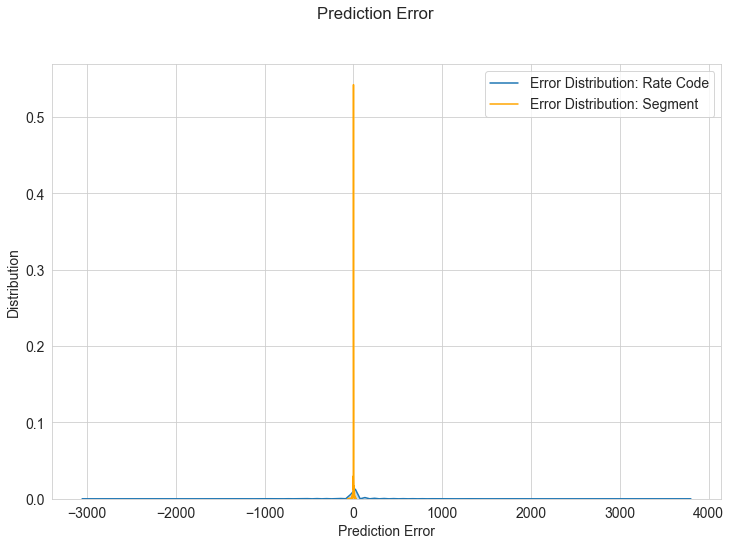

In [109]:
import matplotlib.pyplot as plt 
import seaborn as sns

plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(figsize=(12,8))
sns.set_style('whitegrid')
fig.suptitle('Prediction Error')

sns.kdeplot(code_error['ratecode_error'], label='Error Distribution: Rate Code', shade=True);
sns.kdeplot(clust_error['cluster_error'], label='Error Distribution: Segment', shade=True, color="orange")
plt.xlabel('Prediction Error'); plt.ylabel('Distribution'); 

# save
fig.savefig(location+'error_dist.png')